# Heuristics Lab
The goal of this lab is to gain experience using heuristics in tandem with other algorithms.

For the purposes of this assignment, you will be implementing a solver for the "2048" game (whose implementation will already be given to you). Before continuing, the following cell contains any dependencies you may need for this assignment: 

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from game import Board

You should also look at `game.py` to understand how the in-line version has been implemented. 

## Background Info

2048 is a single-player sliding block puzzle game played on a 4x4 grid where tiles containing even numbers can be moved around and merged to create larger numbers. If this does not ring a bell, it is highly recommended that you play the game at some point (enjoy the cupcake version [here](https://0x0800.github.io/2048-CUPCAKES/)).

While the implementation has been given, ensure that you understand what a tile, a turn, a legal move, and when the game ends is.

This particular implementation/walk through focuses on utilization of heuristic functions themselves (or strategies that are simple enough that a human player could follow them) & only looks ahead by 1 move (as opposed to adding this heuristic into another algorithm like nimimax or expectimax - which would yield better results)

Questions: 
1. What is a potential representation of the solution space?
2. How can you evaluate the results of a single move? 
3. How might you select and combine heuristics?
4. How can you evaluate the results of an entire game?


## A. Assessing the Problem

What is a potential representation of the solution space?

**The solution space for 2048 can be represented as a directed graph where:**

- Each node is a state of the 4x4 board
- Each edge represents a move (up, down, left, right)
- The goal is to reach a state containing the 2048 tile
- At each step, we need to decide the best direction to move based on some evaluation criteria

**Play a SINGLE round of 2048 (you can do this on the website with the nice UI instead of the text version). What score did you get?**

20576 :D this was such a distraction LOL


## B. Evaluating a Single Move

Before implementing specific heuristics, a general implementation procedure must be formed.

Use the following pseudocode to write a function to evaluate a game _G_ in its current state:

**Input:** _G_ - a game, _M_ - a set of moves \
**Output:** The best moves according to the specific evaluator

**procedure** EvaluateGame(_G_, _M_)\
&emsp;_bestScore_ ← −1\
&emsp;_bestMoves_ ← ∅\
&emsp;**for all** _move_ ∈ _M_ **do**\
&emsp;&emsp;_G'_ ← _G_\
&emsp;&emsp;apply _move_ to _G'_\
&emsp;&emsp;_curScore_ ← the score given by the evaluator’s specific criteria\
&emsp;&emsp;**if** _curScore_ > _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestScore_ ← _curScore_\
&emsp;&emsp;&emsp;_bestMoves_ ← {_move_}\
&emsp;&emsp;**else if** _curScore_ = _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestMoves_ ← _bestMoves_ ∪ {_move_}\
&emsp;&emsp;**end if**\
&emsp;**end for**\
&emsp;return _bestMoves_\
**end procedure**

For now, use the overall game score as the evaluation criteria. Remember to consider how the game/board is referenced when running each move.

In [2]:
def evaluate_game(game, moves):
    best_score = -1
    best_moves = []
    
    for move in moves:
        game_copy = Board()
        game_copy.board = game.board.copy()
        game_copy.score = game.score
        
        game_copy.move(move)
        
        cur_score = game_copy.score
        
        if cur_score > best_score:
            best_score = cur_score
            best_moves = [move]
        elif cur_score == best_score:
            best_moves.append(move)
            
    return best_moves

## C. Selecting Heuristics

### Refactoring Evaluation

At this point in time, the solver uses a 'greedy' heuristic of purely selecting tiles based on the highest immediate increase to score.  Before we try other heuristics, let's refactor the `evaluate_move()` function to take in a heuristic function instead of hardcoding the evaluator's criteria. 

After updating the function, it can be tested with the given `game_score()` heuristic function.

In [4]:
def game_score(game):
    return game.score

def evaluate_game(game, moves, heuristic):
    best_score = -1
    best_moves = []
    
    for move in moves:
        game_copy = Board()
        game_copy.board = game.board.copy()
        game_copy.score = game.score
        
        game_copy.move(move)
        
        cur_score = heuristic(game_copy)
        
        if cur_score > best_score:
            best_score = cur_score
            best_moves = [move]
        elif cur_score == best_score:
            best_moves.append(move)
            
    return best_moves

We should also define a random move selection function as a groud zero/baseline point of comparison.

In [22]:
def random_move(moves):
    if moves:
        return random.choice(moves)
    return None

### Various Heuristics

There are multiple heuristics that can be used to solve a 2048 game: 
- Greedy - approximates in-game score after each move & return the one with the highest result
- Monotincity - values are either non-increasing or non-decreasing along all rows and non-increasing or non-decreasing along all columns
- Empty - prioritizes moves that increases the # of empty tiles on the board
- Smoothness - keeps tiles of similar value close to each other
- Weight matrix - a grid w higher weighting tiles on one part of the grid (resulting in higher utility & the algorithm shifting tiles/converging them on one corner of weights)

Pick two heuristics (other than greedy - which you already did) & write functions calculating those. You may choose another heuristic that is not on this list if you would prefer that.

In [36]:
def empty_tiles_heuristic(game):
    """
    Prioritizes moves that increases the # of empty tiles on the board
    """
    empty_count = np.count_nonzero(game.board==0)
    return empty_count * 50 + game.score
def smoothness_heuristic(game):
    """
    Keeps tiles of similar value close to each other
    """
    smoothness = 0
    board = game.board
    
    for r in range(4):
        for c in range(3):
            if board[r, c] != 0 and board[r, c+1] != 0:
                difference = abs(board[r, c] - board[r, c+1])
                smoothness -= difference
    
    for r in range(3):
        for c in range(4):
            if board[r, c] != 0 and board[r+1, c] != 0:
                difference = abs(board[r, c] - board[r+1, c])
                smoothness -= difference
    
    return smoothness + game.score
    

## D. Evaluating a Game

### Making the Solver

Now that value has successfully been equated to the outcome of a single move, this needs to be done on the entire game. 

To start, your solver should take in a game and a heuristic to abide by. 

Most heuristic evaluators are non-terminal, meaning they will return more than one possible move of equal value. In order to combat this, a terminal evaluator must be included in the overall game solver to ensure only one move is selected. This can be done by randomly selecting from the list of "best moves" provided by the heuristic. 

In [12]:
def run_solver(game, heuristic):
    moves = ['a','s','w','d']
    while game.has_valid_moves():
        best_moves = evaluate_game(game, moves, heuristic)
        if not best_moves:
            move_choice = random_move(moves)
        else:
            move_choice = random.choice(best_moves)
        game.play_turn(move_choice)
    game.display()

Run the following cell to test your solver on just the `game_score` heuristic:

In [13]:
g = Board()
run_solver(g, game_score)

Score: 2440
[[  2   4   8   2]
 [ 32   8 256  64]
 [  8  32   8   2]
 [  2  16   2   8]]


Try the full game solver on some of your other heuristics. Note that sometimes they will flatline or get stuck in a pattern of moves that do not appear to converge in a termination point.

In [9]:
game = Board()
run_solver(game, empty_tiles_heuristic)

KeyboardInterrupt: 

In [ ]:
game = Board()
run_solver(game, smoothness_heuristic)

#### Resolving Flatlining

One way to resolve flatlining is to to update the solver to count for a certain number of repeating moves and reintroduce a random selection.

In [52]:
def run_solver(game, heuristic): 
    threshold = 5
    previous_move = None
    repeat_count = 0
    
    moves = ['a','s','w','d']
    
    while game.has_valid_moves():
        best_moves = evaluate_game(game, moves, heuristic)
        if not best_moves:
            move_choice = random_move(moves)
        elif repeat_count >= threshold:
            available_moves = [m for m in moves if m != previous_move]
            if not available_moves:
                available_moves = moves
            move_choice = random_move(available_moves)
            repeat_count = 0
        else:
            move_choice = random.choice(best_moves)
        
        valid_move = game.play_turn(move_choice)
        
        if move_choice == previous_move and valid_move:
            repeat_count += 1
        else:
            repeat_count = 0
        previous_move = move_choice
    game.display()
    return game.score

#### Combining Heuristics 

A simple way to incorporate multiple heuristics is to create a `combined_heuristic()` function that assigns weights to various heuristics. These weights can also help offset any discrepancies in the scale of resulting "scores".

The combined score should be calculated by multiplying the weight of an individual heuristic's score with its score.

In [44]:
def combined_heuristic(game):
    
    # Heuristic 1 (Replace with your code)
    empty_count = np.count_nonzero(game.board==0)

    # Heuristic 2 (Replace with your code)
    smoothness = 0
    board = game.board
    
    for r in range(4):
        for c in range(3):
            if board[r, c] != 0 and board[r, c+1] != 0:
                difference = abs(board[r, c] - board[r, c+1])
                smoothness -= difference
    
    for r in range(3):
        for c in range(4):
            if board[r, c] != 0 and board[r+1, c] != 0:
                difference = abs(board[r, c] - board[r+1, c])
                smoothness -= difference
    
    # Assign weights to each heuristic
    score_weight = 1    
    empty_weight = 50   
    smooth_weight = 1
    
    combined_score = (
        score_weight * game.score +
        empty_weight * empty_count +
        smooth_weight * smoothness
    )

    return combined_score

In [53]:
g = Board()
run_solver(g, combined_heuristic)

Score: 1664
[[  4   8  16   2]
 [ 16  64   8   4]
 [  8 128  32  64]
 [  4  16   8   2]]


1664

### Plotting Results

Run 100 cycles of each of your heuristics & plot your results. You should have at least 3 lines (score, your heuristic #1, your heuristic #2, and potentially a completely random implementation)

In [56]:
# Run experiments
iterations = 100
score_results = []
smoothness_results = []
empty_tiles_results = []
combined_results = []

for _ in range(100):
    g = Board()
    score_results.append(run_solver(g, game_score))
    g = Board()
    smoothness_results.append(run_solver(g, smoothness_heuristic))
    g = Board()
    empty_tiles_results.append(run_solver(g, empty_tiles_heuristic))
    g = Board()
    combined_results.append(run_solver(g, combined_heuristic))


Score: 1360
[[  2   8  16   8]
 [  4 128  64   2]
 [ 16   8  32  16]
 [  4   2   4   2]]
Score: 1404
[[  2   4 128   2]
 [  4   8  64   4]
 [ 32  16  32   2]
 [  2   4   8   4]]
Score: 2868
[[  8  32   4   2]
 [128   8 256  16]
 [  4  32   8   2]
 [  2   4   2   8]]
Score: 2920
[[ 16   4   2 256]
 [  4   8  32   2]
 [ 16 128  16   8]
 [  2  32   4   2]]
Score: 2896
[[  2   4  16   4]
 [  8 128   8  16]
 [ 32 256  32   4]
 [  8   4   8   2]]
Score: 4780
[[  4   2   4   2]
 [ 16  64   2  16]
 [  4  16  64 512]
 [ 16   4   2   4]]
Score: 1096
[[  2  16   8   4]
 [  4   2 128  16]
 [  8  16  32   4]
 [  2   4  16   2]]
Score: 1564
[[  2  32   4   2]
 [  4 128  64  32]
 [ 16  32   4  16]
 [  2   8   2   8]]
Score: 940
[[ 2 16  8  2]
 [ 4  8 16  4]
 [16 64 32 64]
 [ 4  8  4  2]]
Score: 2428
[[  2   4   8  32]
 [  4 256  64   8]
 [  8  16  32   4]
 [  2   4   8  16]]
Score: 1544
[[  2   4  64   2]
 [  4   8 128   8]
 [ 16  64  32   4]
 [  4   2   4   2]]
Score: 2304
[[  2   8  64   2]
 [  8  

Score: 3036
[[  4   8   4   2]
 [  2  32 256   8]
 [128  16  64  16]
 [  8   2   4   2]]
Score: 2328
[[  2   4   8   2]
 [ 16 256   4  16]
 [  4  16   2   4]
 [  2  32  64   2]]
Score: 1296
[[  2  16   8   2]
 [  8 128   2  64]
 [ 16   8  32   2]
 [  2   4   2   4]]
Score: 2440
[[  2   4   2   8]
 [  4   8  16 256]
 [  8  32   8  16]
 [  2  64  32   4]]
Score: 1188
[[  4   2   4  16]
 [  2  16   8   2]
 [ 64 128   2   4]
 [  2   4  16   2]]
Score: 5036
[[  4  64   4   2]
 [  8  32  16   4]
 [ 32 512  64   8]
 [  2   8  16   2]]
Score: 3556
[[  2   4  32   4]
 [ 16 256   8  16]
 [  2  16 128   4]
 [128   4   8   2]]
Score: 1428
[[  4 128   8   2]
 [  8  32  16   4]
 [  4  64  32   2]
 [  2  16   2   4]]
Score: 1164
[[  2   4   2   4]
 [  4   8 128  16]
 [ 32  16  32   4]
 [  4   2   4  16]]
Score: 2752
[[  2   8   4   2]
 [  8  16  32   8]
 [ 16 256 128   4]
 [  2   8   4   2]]
Score: 1400
[[  4 128  16   2]
 [  2  16  64  32]
 [ 16   4  16   8]
 [  4   2   8   2]]
Score: 3260
[[  4  32

Score: 2548
[[  4  16   4   2]
 [  2   4   8  64]
 [256  64  16   8]
 [  4   2   4  16]]
Score: 2624
[[  2  16   4   2]
 [  8 256  16   4]
 [  2   8  32  64]
 [ 64   2   4   8]]
Score: 3024
[[  2   8  32   4]
 [ 32 128 256  16]
 [  4  16  32   8]
 [  2   4   2  16]]
Score: 3068
[[  2   8  16   2]
 [256  64 128   4]
 [  2  32  16   8]
 [  4   8   4   2]]
Score: 1744
[[  2   4 128   2]
 [  8  32   4  16]
 [  2 128   8   4]
 [  8   4  16   2]]
Score: 1516
[[  8   4  16   2]
 [  2  64 128   8]
 [  4   8  16   2]
 [  2  64   2   4]]
Score: 1736
[[  2   8  64   2]
 [ 32  16  32   4]
 [  8  64 128  16]
 [  4   8   4   2]]
Score: 2488
[[  2   8   4  16]
 [ 64  16 256  32]
 [  8  32  16   4]
 [  2   8   4   2]]
Score: 3040
[[  2  32   2  16]
 [256  16   8   2]
 [  4   2   4  64]
 [  2   8   2 128]]
Score: 1356
[[  2 128   4   2]
 [ 16   4  32  16]
 [ 64   8  16   8]
 [  2   4   8   4]]
Score: 1676
[[  4  16   4   2]
 [  8  64 128  16]
 [ 64  16  32   8]
 [  2   4   8   2]]
Score: 1476
[[  2   4

Score: 3160
[[  2  64   4   2]
 [ 16 128  32   8]
 [  2  32 256   4]
 [  4  16   8   2]]
Score: 3064
[[  2   4   8   4]
 [ 16  32 128  16]
 [  4  64 256   4]
 [  2   8   4   2]]
Score: 1296
[[  2   4   2   4]
 [  4   2   8  16]
 [  2  32  64 128]
 [ 16   2   8   2]]
Score: 1544
[[  2   8   2   4]
 [128  64  32   2]
 [  4   2   4   8]
 [  2  64   8   2]]
Score: 1508
[[  2   8   4   2]
 [  4  16  32   8]
 [ 32  64 128   4]
 [  2  32   8   2]]
Score: 1380
[[  4 128   4   2]
 [  2   4  16   4]
 [ 32   8  64  32]
 [  4   2   4   2]]
Score: 4080
[[  4   8   4   2]
 [  2 256  64 256]
 [ 16  32  16   4]
 [  2   4   8   2]]
Score: 756
[[ 2  8  4  2]
 [ 4  2 32  4]
 [32 64  2  8]
 [ 2 16 32  2]]
Score: 1404
[[  2  16   8   2]
 [  4  32 128  16]
 [  2  16  64   4]
 [ 16   4   8   2]]
Score: 1516
[[  2  32   4   8]
 [  4 128  64  16]
 [ 32   4   8   4]
 [  4  32   4   2]]
Score: 1016
[[ 4  8  4  2]
 [ 8 64 32  8]
 [ 4 32 16 64]
 [ 2 16  8  2]]
Score: 2472
[[  2  32   8   2]
 [  4   2  64   4]
 [  

Score: 2340
[[  8   2  32   2]
 [  2   8 256   4]
 [  8  64   8  16]
 [  2   8  16   8]]
Score: 2952
[[ 16   8   4   2]
 [  4  64 128 256]
 [  2  16   4   2]
 [  8   2   8   4]]
Score: 1720
[[  4   2   4   2]
 [  2  32  64  32]
 [ 64   8  16   8]
 [  2   4 128   2]]
Score: 2984
[[  2 256   2   8]
 [  4  32   4   2]
 [  8   2   8  64]
 [  2 128   4   2]]
Score: 2448
[[  2   4   2   8]
 [256  32   8   2]
 [ 16   8  64  16]
 [  4  32   8   2]]
Score: 3272
[[  4   2   4 256]
 [128  64   8   2]
 [  4  16  64   8]
 [  2   8  16   2]]
Score: 2036
[[  4   2  16   2]
 [  2  16 256   8]
 [  8   2  32   4]
 [  2  16   4   2]]
Score: 1308
[[  2 128   2   4]
 [  4  64   4   2]
 [ 16   2  16   4]
 [  4  16  32   2]]
Score: 2004
[[  2   4   8   4]
 [  8 256  16   8]
 [  4   8  32   4]
 [  2   4   8   2]]
Score: 1420
[[  4  16   2   8]
 [128  64  32   2]
 [  2   4   8  32]
 [  4   8   4   2]]
Score: 1296
[[  4   8  64   2]
 [  2  16   2   4]
 [  8 128  32  16]
 [  2   4   8   2]]
Score: 2452
[[  2   4

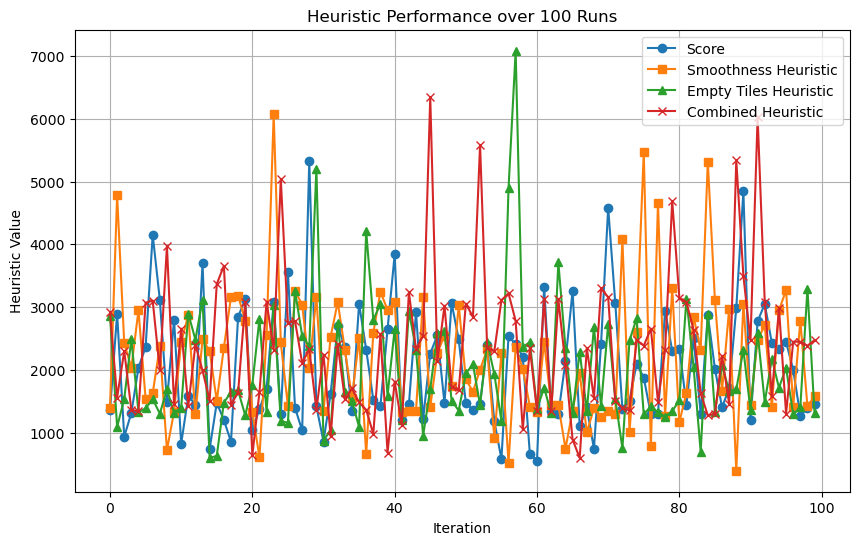

In [57]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), score_results, label="Score", linestyle='-', marker='o')
plt.plot(range(iterations), smoothness_results, label="Smoothness Heuristic", linestyle='-', marker='s')
plt.plot(range(iterations), empty_tiles_results, label="Empty Tiles Heuristic", linestyle='-', marker='^')
plt.plot(range(iterations), combined_results, label="Combined Heuristic", linestyle='-', marker='x')
plt.xlabel("Iteration")
plt.ylabel("Heuristic Value")
plt.title("Heuristic Performance over 100 Runs")
plt.legend()
plt.grid()
plt.show()